# House Prices: Advanced Regression Techniques

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

Data from https://www.kaggle.com/dejavu23/house-prices-eda-to-ml-beginner

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Let's find out more details about our dataset.

In [3]:
print(train.shape)
print(test.shape)
print(train.head())
print(train.columns)

(1460, 81)
(1459, 80)
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice 

We should first clean the data before doing any analysis on it. Let's check if there are any missing values.

In [4]:
null = train.isnull().sum().sort_values(ascending=False)
print(null)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
LotFrontage       259
GarageCond         81
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageQual         81
BsmtExposure       38
BsmtFinType2       38
BsmtFinType1       37
BsmtCond           37
BsmtQual           37
MasVnrArea          8
MasVnrType          8
Electrical          1
Utilities           0
YearRemodAdd        0
MSSubClass          0
Foundation          0
ExterCond           0
ExterQual           0
Exterior2nd         0
Exterior1st         0
RoofMatl            0
RoofStyle           0
YearBuilt           0
                 ... 
GarageArea          0
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
3SsnPorch           0
BsmtUnfSF           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SaleType            0
Functional          0
TotRmsAbvGrd        0
KitchenQua

There are 19 columns with missing values. We want to know the reason behind missing values, so that we would be able to determine if the columns should be kept or otherwise. 

In [5]:
null = null[0:19]
ratio = (null / len(train)) * 100
missing_data = pd.DataFrame({'missing ratio' :ratio})
missing_data = pd.concat([null, ratio], axis=1, keys=['Numbers of Null', 'Percentage of Null'])
print(missing_data)

              Numbers of Null  Percentage of Null
PoolQC                   1453           99.520548
MiscFeature              1406           96.301370
Alley                    1369           93.767123
Fence                    1179           80.753425
FireplaceQu               690           47.260274
LotFrontage               259           17.739726
GarageCond                 81            5.547945
GarageType                 81            5.547945
GarageYrBlt                81            5.547945
GarageFinish               81            5.547945
GarageQual                 81            5.547945
BsmtExposure               38            2.602740
BsmtFinType2               38            2.602740
BsmtFinType1               37            2.534247
BsmtCond                   37            2.534247
BsmtQual                   37            2.534247
MasVnrArea                  8            0.547945
MasVnrType                  8            0.547945
Electrical                  1            0.068493


From the data documentation, we found out that null value on PoolQC means that the house has no pool. Similar idea applies to the other columns. In addition, there are other variables presented in the datat that describe the house better. For example, there is a varaible called "PoolArea" and the value of it would be 0 if there is no pool, which is a much better representation than the PoolQC. Since we can find other columns describing the same feature, we will be removing all columns with null values, except for "Electrical" which only has one missing value. Instead, we will remove the row with a missing value in "Electrical".


In [6]:
null = null.drop(["Electrical"])
train = train.drop(null.index, axis=1)
train = train.dropna(axis=0, subset=['Electrical'])
test = test.drop(null.index, axis=1)

Let's check if there are any missing values in the test set as well after removing the columns.

In [7]:
null_test = test.isnull().sum().sort_values(ascending=False)
null_test = null_test[0:19]
print(null_test)
print("There are", test.isnull().sum().sum(), "missing values rows")

MSZoning        4
BsmtHalfBath    2
BsmtFullBath    2
Functional      2
Utilities       2
Exterior2nd     1
KitchenQual     1
GarageCars      1
GarageArea      1
BsmtFinSF1      1
SaleType        1
TotalBsmtSF     1
BsmtUnfSF       1
BsmtFinSF2      1
Exterior1st     1
OverallCond     0
RoofMatl        0
ExterQual       0
RoofStyle       0
dtype: int64
There are 22 missing values rows


Since there are not too many missing values in the test set after removing the columns, I will just remove the data points with missing values.

In [8]:
test = test.dropna(axis=0)
print(test.isnull().sum().sum())

0


Preparation for prediction, we will not need the id for prediction

In [9]:
test_id = test["Id"]
test.drop("Id", axis = 1, inplace = True)
train.drop("Id", axis = 1, inplace = True)

Let's doublecheck the shape and the missing values of our sets before continuing

In [10]:
print("There are", train.isnull().sum().sum(), "missing values in the train set")
print("There are", test.isnull().sum().sum(), "missing values in the test set")
print("Shape of the train set: ",train.shape)
print("Shape of the test set: ",test.shape)

numerical_feats = train.dtypes[train.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))
categorical_feats = train.dtypes[train.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

There are 0 missing values in the train set
There are 0 missing values in the test set
Shape of the train set:  (1459, 62)
Shape of the test set:  (1447, 61)
Number of Numerical features:  34
Number of Categorical features:  28


There is one extra column in the train set (SalePrice), because we need to make the prediction on the Sale Price in the test set.

Now, we will check the correlation between the variables and the Sale Price in a style of heatmap


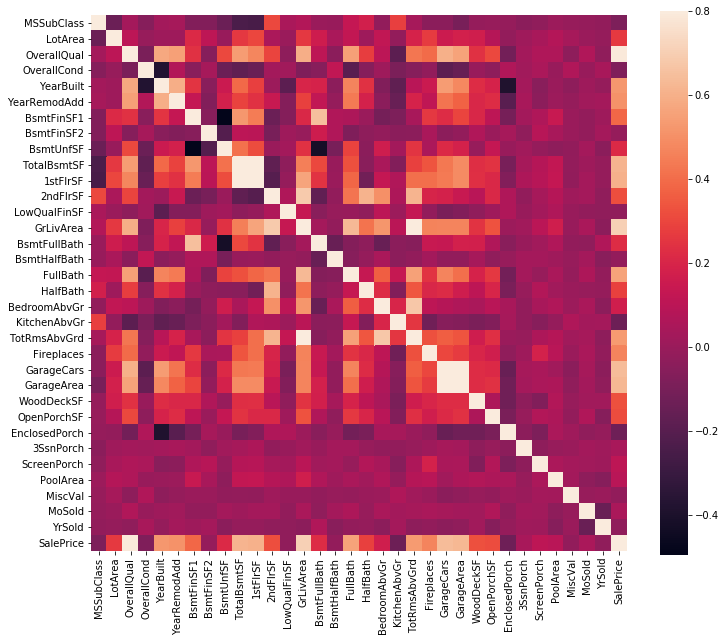

In [11]:
corr = train.corr()
plt.subplots(figsize=(12, 10))
sns.heatmap(corr, square= True, vmax = 0.8)
plt.show()

Let's cut down the variables to 10 and see if we can get better insights from the heatmap

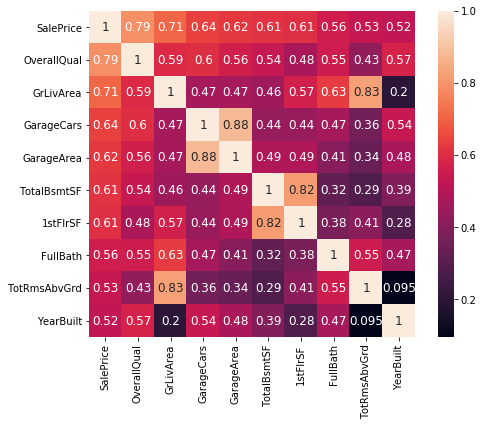

In [12]:
column = corr.nlargest(10, "SalePrice")['SalePrice'].index
top10 = np.corrcoef(train[column].T)
plt.subplots(figsize=(8, 6))
hm = sns.heatmap(top10, square=True, annot=True, annot_kws={'size': 12}, yticklabels=column.values, xticklabels=column.values)
plt.show()

We see the strong correlation of Sale Price from Overall Quality of the house. It looks like people put the most focus on the quality of the house when it comes to buying a new home. I expected that the location of the house would be one of the biggest factor when it comes to buying a house. In fact, the correlation of the location/neighbourhood is not even included in the top 9 correlation with Sale Price. 

Secondly, there is also two white squares present in the middle of the heatmap, suggests that there are two varables strong correlated to each other. GarageCars and GarageArea have high correlation because they essentially represent the same feature of a house. The same applies to **TotalBsmtSF** and **1stFlrSF**. We want to drop these columns that show correlations with another column as they represent similar features of the house. Therefore, removing it would benefit our regression model. 
We will drop the two that has smaller correlation with **SalePrice** : **1StFlrSF and GarageArea**

Let's take a closer look to each variables and see if we would find anything that would negatively impact our prediction and anlysis.

In [13]:
for col in numerical_feats:
    print('{:}'.format(col), 
          'Skewness: {:05.2f}'.format(train[col].skew()) , 
          '   ' ,
          'Kurtosis: {:06.2f}'.format(train[col].kurt())  
         )

MSSubClass Skewness: 01.41     Kurtosis: 001.58
LotArea Skewness: 12.20     Kurtosis: 203.10
OverallQual Skewness: 00.22     Kurtosis: 000.10
OverallCond Skewness: 00.69     Kurtosis: 001.10
YearBuilt Skewness: -0.61     Kurtosis: -00.44
YearRemodAdd Skewness: -0.50     Kurtosis: -01.27
BsmtFinSF1 Skewness: 01.69     Kurtosis: 011.12
BsmtFinSF2 Skewness: 04.25     Kurtosis: 020.10
BsmtUnfSF Skewness: 00.92     Kurtosis: 000.47
TotalBsmtSF Skewness: 01.53     Kurtosis: 013.28
1stFlrSF Skewness: 01.38     Kurtosis: 005.75
2ndFlrSF Skewness: 00.81     Kurtosis: -00.55
LowQualFinSF Skewness: 09.01     Kurtosis: 083.17
GrLivArea Skewness: 01.37     Kurtosis: 004.89
BsmtFullBath Skewness: 00.59     Kurtosis: -00.84
BsmtHalfBath Skewness: 04.10     Kurtosis: 016.38
FullBath Skewness: 00.04     Kurtosis: -00.86
HalfBath Skewness: 00.68     Kurtosis: -01.07
BedroomAbvGr Skewness: 00.21     Kurtosis: 002.23
KitchenAbvGr Skewness: 04.49     Kurtosis: 021.51
TotRmsAbvGrd Skewness: 00.68     Kurtos

There are some variables that I want to see in plot as the skewness is very high. We can determine if such variables would require a transformation. We could also see if there are any significant outliers/influenctial points.

Text(0.5, 0, 'OverallQual')

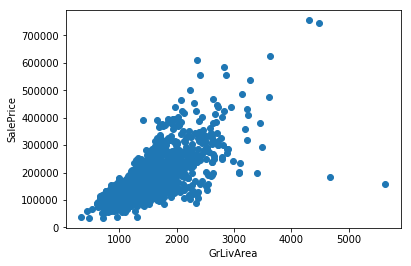

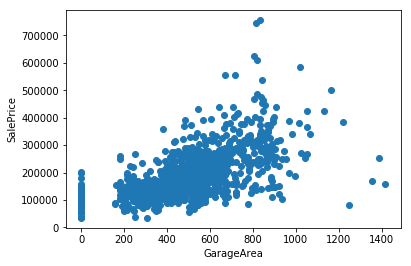

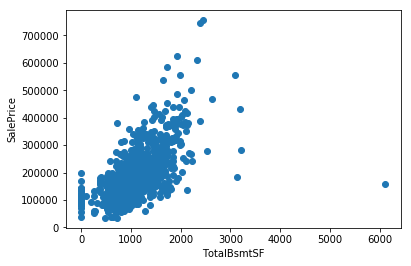

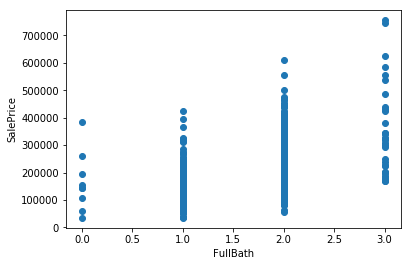

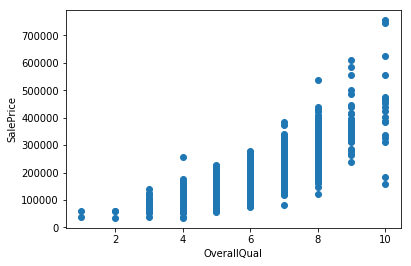

In [14]:
plt.subplots()
plt.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GrLivArea')

plt.subplots()
plt.scatter(x = train['GarageArea'], y = train['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GarageArea')

plt.subplots()
plt.scatter(x = train['TotalBsmtSF'], y = train['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('TotalBsmtSF')


plt.subplots()
plt.scatter(x = train['FullBath'], y = train['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('FullBath')

plt.subplots()
plt.scatter(x = train['OverallQual'], y = train['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('OverallQual')

There are some very obvious outliers and I will delete them. However, I do not want to delete too many as the outliers could have a very important meaning. For example, I decided to delete the points with two biggest ground living area with very cheap price. It is a big sign of an outlier that would not benfift our model.

In [15]:
train = train.drop(train[(train["GrLivArea"] > 4000) & (train["SalePrice"] < 300000)].index)
train = train.drop(train[(train["GarageArea"] > 1200) & (train["SalePrice"] < 300000)].index)
train = train.drop(train[(train["TotalBsmtSF"] > 3000) & (train["SalePrice"] < 400000)].index)
train = train.drop(train[(train["FullBath"] < 0.5 ) & (train["SalePrice"] > 300000)].index)

[Text(0, 0.5, 'Sale Price'), Text(0.5, 0, 'FullBath')]

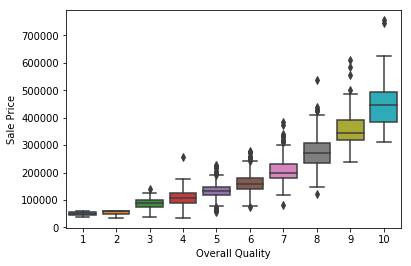

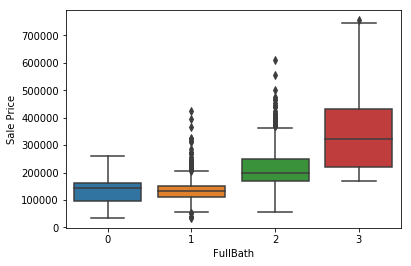

In [16]:
plt.subplots()
ax = sns.boxplot(x="OverallQual", y = "SalePrice", data = train)
ax.set(xlabel="Overall Quality",ylabel="Sale Price")

plt.subplots()
ax = sns.boxplot(x="FullBath", y = "SalePrice", data = train)
ax.set(xlabel="FullBath",ylabel="Sale Price")

The overall quality box plot is very reasonable with the higher the overall quality, the higher the sale price. Whereas the **FullBath**, people do not seem to care too much about having a full bath. However, we could see from the scatterplot that there are not many points with 0 **FullBath**, so the data with 0 bathrooms might not be accurate. Though, the rest of the graph makes a lot of sense with the more full baths presented in the house, the higher of the sale price.

Next, we will check the normality of the variables with the distribution plot and the QQ-plot, as couple skewed variables are spotted in our previous codes.

The skewness of the Sale Price is:  1.8926024825671226
The skewness of the Lot Area is:  12.797939547860748


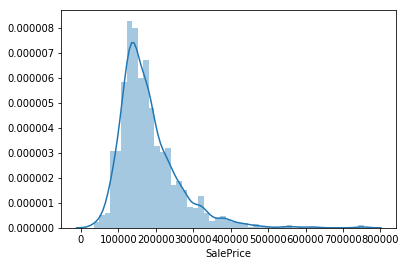

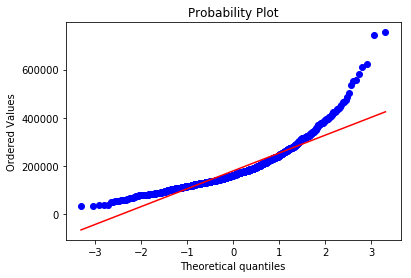

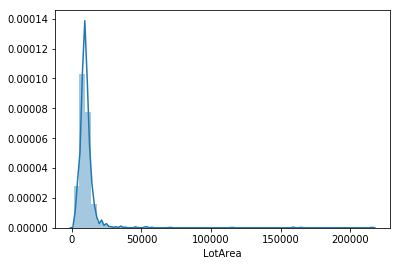

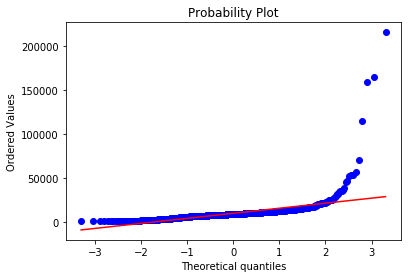

In [17]:
from scipy import stats
from scipy.stats import norm
plt.subplots()
sns.distplot(train['SalePrice']);
plt.subplots()
res = stats.probplot(train['SalePrice'], plot=plt)
print("The skewness of the Sale Price is: ", train.SalePrice.skew())

plt.subplots()
sns.distplot(train['LotArea']);
plt.subplots()
res = stats.probplot(train['LotArea'], plot=plt)
print("The skewness of the Lot Area is: ", train.LotArea.skew())

Our intuitions were right and that the two variables, **SalePrice and LotArea**, are positvely skewed. Though, it usualy could be solved easily by log transformation. Since our variables have a tendency of growing expoentially, a log transofmraiton would be very helpful in our situation. 

We will be using log1p = log(1+x) instead of log to prevent getting errors when the input is 0.

In [18]:
#log1p = log(1+x) prevent getting errors if the input is 0.
train["SalePrice"] = np.log1p(train["SalePrice"])
train["LotArea"] = np.log1p(train["LotArea"])

Let's double check if the transformation was helpful.

The skewness of the Sale Price is:  0.12352883435577916
The skewness of the Lot Area is:  -0.20624409327720666


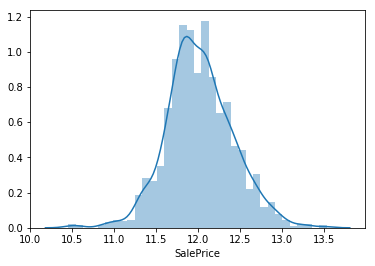

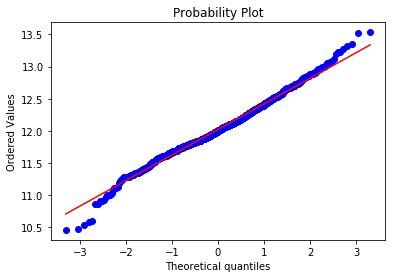

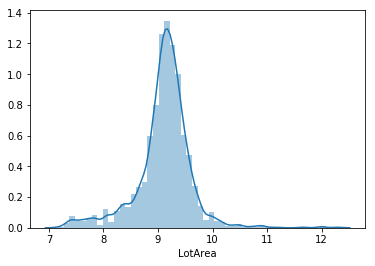

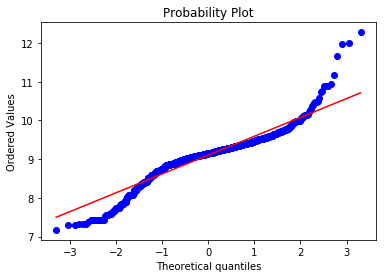

In [19]:
plt.subplots()
sns.distplot(train['SalePrice']);
plt.subplots()
res = stats.probplot(train['SalePrice'], plot=plt)
print("The skewness of the Sale Price is: ", train.SalePrice.skew())

plt.subplots()
sns.distplot(train['LotArea']);
plt.subplots()
res = stats.probplot(train['LotArea'], plot=plt)
print("The skewness of the Lot Area is: ", train.LotArea.skew())

In [20]:
#For future use when predicting the test set and to drop some columns that were mentioned before
y = train["SalePrice"]

train = train.drop(['1stFlrSF'], axis=1)
train = train.drop(["GarageArea"], axis=1)
train = train.drop(["SalePrice"], axis=1)
test = test.drop(["1stFlrSF"], axis=1)
test = test.drop(["GarageArea"], axis=1)

Before we run the regression prediction, we need to turn our categorical variables to dummy variables for prediction purpose.

In [21]:
print("Train before dummy, ", train.shape)
print("Test before dummy, ", test.shape)

all_data = pd.concat((train, test))
all_data = pd.get_dummies(all_data)
train = all_data[:train.shape[0]]
test  = all_data[train.shape[0]:]

print("Train After dummy, ",train.shape)
print("Test After dummy, ",test.shape)

Train before dummy,  (1452, 59)
Test before dummy,  (1447, 59)
Train After dummy,  (1452, 217)
Test After dummy,  (1447, 217)


There are many uncertainty with the codes I try to run below. I tried running Lasso, ridge, and linear but they give me prediction that are very small Sale Price. I believe it is not flaw on the idea of the code, but some order of the codes that are presented. I will defeintely spend more time in the future on this project. Overall, it has really helped me translate my machine learning and data visualizing skills from R to Python.

In [22]:
from sklearn.model_selection import GridSearchCV


from sklearn.linear_model import Lasso

lasso = Lasso()
parameters = {'alpha':[1e-03,0.01,0.1,0.5,0.8,1], 'normalize':[True,False], 'max_iter':[10000], 'tol':[1e-06,1e-05,5e-05,1e-04,5e-04,1e-03]}
grid_lasso = GridSearchCV(lasso, parameters, cv=9, verbose=1)
grid_lasso.fit(train, y)


pred_lasso = grid_lasso.predict(test)



Fitting 9 folds for each of 72 candidates, totalling 648 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 648 out of 648 | elapsed:   25.2s finished


In [23]:
prediction = pd.DataFrame()
prediction['Id'] = test_id
print(test_id.shape)
print(pred_lasso.shape)
prediction['SalePrice'] = pred_lasso
prediction['SalePrice'] = prediction['SalePrice'].astype(float)
prediction.to_csv('prediction.csv',index=False)

(1447,)
(1447,)


In [24]:
from sklearn.model_selection import GridSearchCV
score_calc = 'neg_mean_squared_error'

from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_linear = GridSearchCV(linreg, parameters, cv=5, verbose=1 , scoring = score_calc)
grid_linear.fit(train, y)

pred_linear = grid_linear.predict(test)
pred_linear[pred_linear < 0] = pred_linear.mean()

pred_linreg = pd.DataFrame()
pred_linreg['Id'] = test_id
pred_linreg['SalePrice'] = pred_linreg
pred_linreg.to_csv('linreg.csv',index=False)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.7s finished
C:\Users\Kaiden\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [25]:
import sys
sys.version

'3.7.1 (default, Dec 10 2018, 22:54:23) [MSC v.1915 64 bit (AMD64)]'